In [1]:
from ubibetter.models.compute_fraction  import compute_fraction
from ubibetter.utils.data.get_neigbours import get_neighbours
from ubibetter.models.compute_fraction import compute_fraction
from betbrain.manager.data_manager import data_manager

import pandas as pd
import numpy as np

from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dm = data_manager(sport='Tennis')

In [3]:
data = dm.__get_tennis_data__()

In [4]:
data.head()

odds        prob         book FTR
                                       0     1     0     1           
MatchDate  Winner    Loser     bkmr                                  
2001-01-01 Agenor R. Zib T.    CB    2.3  1.53  0.40  0.60  0.088   0
                               GB    1.8  1.66  0.48  0.52  0.158   0
                               IW    1.9  1.50  0.44  0.56  0.193   0
           Arazi H.  Portas A. CB    3.1  1.33  0.30  0.70  0.074   1
                               GB    2.5  1.35  0.35  0.65  0.141   1

In [5]:
train = data[data.index.get_level_values(0) < datetime(2019, 1, 1)]
test  = data[data.index.get_level_values(0) > datetime(2019, 1, 1)]

In [6]:
matrix = dm.ubibetter.get_matrix(train,[('prob', 0), ('prob', 1), 'book', 'FTR'])

/Users/Gabriele/Library/Mobile Documents/com~apple~CloudDocs/Kellify/Projects/ubipy/env/lib/python3.7/site-packages/pandas/core/generic.py:3947: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [7]:
matrix.head()

book                     -0.726  -0.397  -0.350  -0.325  -0.271  -0.237  \
(prob, 0) (prob, 1) FTR                                                   
0.01      0.99      1       0.0     0.0     0.0     0.0     0.0     0.0   
0.02      0.98      0       0.0     0.0     0.0     0.0     0.0     0.0   
                    1       0.0     0.0     0.0     0.0     0.0     0.0   
0.03      0.97      0       0.0     0.0     0.0     0.0     0.0     0.0   
                    1       0.0     0.0     0.0     0.0     0.0     0.0   

book                     -0.233  -0.221  -0.119  -0.104  ...   0.320   0.329  \
(prob, 0) (prob, 1) FTR                                  ...                   
0.01      0.99      1       0.0     0.0     0.0     0.0  ...     0.0     0.0   
0.02      0.98      0       0.0     0.0     0.0     0.0  ...     0.0     0.0   
                    1       0.0     0.0     0.0     1.0  ...     0.0     0.0   
0.03      0.97      0       0.0     0.0     0.0     0.0  ...     0.0     0.0   
                    1       0.0     0.0     0.0     0.0  ...     0.0     0.0   

book                      0.333   0.347   0.391   0.409   0.507   0.584  \
(prob, 0) (prob, 1) FTR                                                   
0.01      0.99      1       0.0     0.0     0.0     0.0     0.0     0.0   
0.02      0.98      0       0.0     0.0     0.0     0.0     0.0     0.0   
                    1       0.0     0.0     0.0     0.0     0.0     0.0   
0.03      0.97      0       0.0     0.0     0.0     0.0     0.0     0.0   
                    1       0.0     0.0     0.0     0.0     0.0     0.0   

book                      0.585   0.818  
(prob, 0) (prob, 1) FTR                  
0.01      0.99      1       0.0     0.0  
0.02      0.98      0       0.0     0.0  
                    1       0.0     0.0  
0.03      0.97      0       0.0     0.0  
                    1       0.0     0.0  

[5 rows x 231 columns]

In [9]:
test   = test.reset_index(level=3).set_index(['book','bkmr'], append=True)
vicini = test.prob.apply(get_neighbours, axis=1).rename('NN').to_frame()

probs  = vicini.apply(dm.ubibetter.__compute_probs__, axis=1, args=[matrix])
probs.columns = pd.MultiIndex.from_tuples([('KLFY', c) for c in probs.columns])

In [10]:
probs.head()

KLFY          
                                                               0         1
MatchDate  Winner           Loser           book  bkmr                    
2019-01-02 Anderson K.      Djere L.        0.067 B365  0.244837  0.755163
                                            0.026 PS    0.257996  0.742004
           Basilashvili N.  Rublev A.       0.081 B365  0.488675  0.511325
                                            0.025 PS    0.545171  0.454829
           Bautista Agut R. Garcia-Lopez G. 0.070 B365  0.211628  0.788372

In [11]:
aux = pd.concat([test.odds.stack().rename('odd'), probs.KLFY.stack().rename('prob')], axis=1, join='inner')
aux = aux.reset_index(level=5).merge(test['FTR'], right_index=True, left_index=True)
aux = aux.reset_index(level=3, drop=True)
aux = aux.rename(columns={'level_5':'level_4'})

In [12]:
aux.head(6)

level_4   odd      prob  FTR
MatchDate  Winner          Loser     bkmr                              
2019-01-02 Anderson K.     Djere L.  PS          0  3.51  0.257996    1
                                     PS          1  1.35  0.742004    1
                                     B365        0  3.75  0.244837    1
                                     B365        1  1.25  0.755163    1
           Basilashvili N. Rublev A. PS          1  1.83  0.454829    0
                                     PS          0  2.09  0.545171    0

In [13]:
frac = aux.groupby(level=[0,1,2,3]).apply(compute_fraction).rename('frac').to_frame()
aux  = pd.concat([aux.set_index('level_4', append=True), frac.round(4)], axis=1).reset_index(level=4)

In [14]:
def perform_simulation(x):
    if x['level_4'] == x['FTR']:
        return (x['odd'] - 1) * x['frac']
    elif x['level_4'] != x['FTR']:
        return -x['frac']

In [15]:
aux['margin'] = aux.apply(perform_simulation, axis=1)

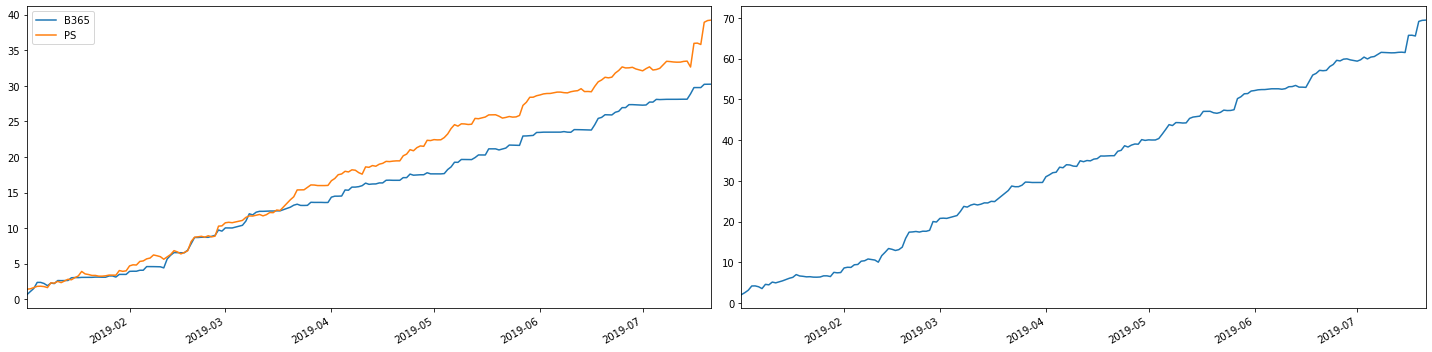

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
aux.margin.groupby(level=[0,3]).sum().unstack().cumsum().plot(ax=ax[0])
aux.margin.groupby(level=[0]).sum().cumsum().plot(ax=ax[1])
plt.tight_layout()